In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download daavoo/3d-mnist

 92% 140M/153M [00:00<00:00, 133MB/s]
100% 153M/153M [00:01<00:00, 156MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/3d-mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py


In [6]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

In [7]:
with h5py.File("/content/full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]
    sample_shape = (16, 16, 16, 3)
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)
    targets_train = to_categorical(targets_train).astype(np.integer)
    targets_test = to_categorical(targets_test).astype(np.integer)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  # Remove the CWD from sys.path while we load stuff.


In [8]:
,model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 14, 14, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 7, 7, 32)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 7, 32)      128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 7, 32)       0         
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 2, 2, 64)      0

Test loss: 2.3635096549987793 / Test accuracy: 0.359499990940094


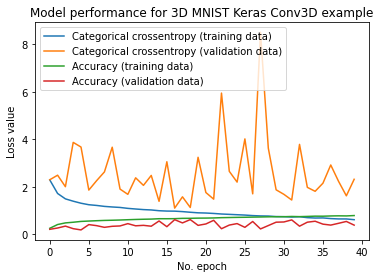

In [11]:
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
